# Remove Redundant Data

In [3]:
import pandas as pd

# Reading a CSV file into a DataFrame, selecting specific columns
fields = ['item_description']
df = pd.read_csv('order_details_202505141508.csv', usecols=fields)

# use for loop to print first 10 rows of the DataFrame
for i in range(20):
    print(df.iloc[i].values[0])

Place Packing List Inside Box and Stamp Box
5 PIECES PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
50 EACH OF ITEM COLOR IN ONE BOX
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
APPLY BARCODE LABELS TO EACH ITEM
5 PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Apply Fragile and Directional labels to all cartons.
Place Packing List Inside Box and Stamp Box
Special Package - POLYBAG ONE OF EACH COLOR
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box	
Place Packing List Inside Box and Stamp Box
3 OF THE FEMALE & 3 OF THE MALE PHYSICIAN IN ONE POLY BAG


In [4]:
print(df.shape)
print("\n\nAfter removing duplicates")
df['item_description'] = df['item_description'].str.lower() # there are lots of words with the same meaning but different cases
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)


for i in range(20):
    print(df.iloc[i].values[0])

# turn it into a list
item_list = df['item_description'].tolist()
print(len(item_list))

(34938, 1)


After removing duplicates
(34938, 1)
(3361, 1)
place packing list inside box and stamp box
5 pieces per polybag
50 each of item color in one box
apply barcode labels to each item
5 per polybag
apply fragile and directional labels to all cartons.
special package - polybag one of each color
place packing list inside box and stamp box	
3 of the female & 3 of the male physician in one poly bag
5 item per poly bag
boxes of 100
special package - 100 per box
special package 25 per polybag
10 per polybag
packages of 25
yellow msb.com labels to outside of all shipping cartons
1 box assorted items
attach nfl hologram sticker
special package - packs of 25
140 of each color per box
3361


# UMAP + HDBSCAN 

UMAP is often preferred for larger datasets or when maintaining both global and local patterns is crucial, while t-SNE might be used for finer cluster analysis in smaller datasets. PCA is generally faster and preferred for preliminary analysis or when the relationships in the data are primarily linear.
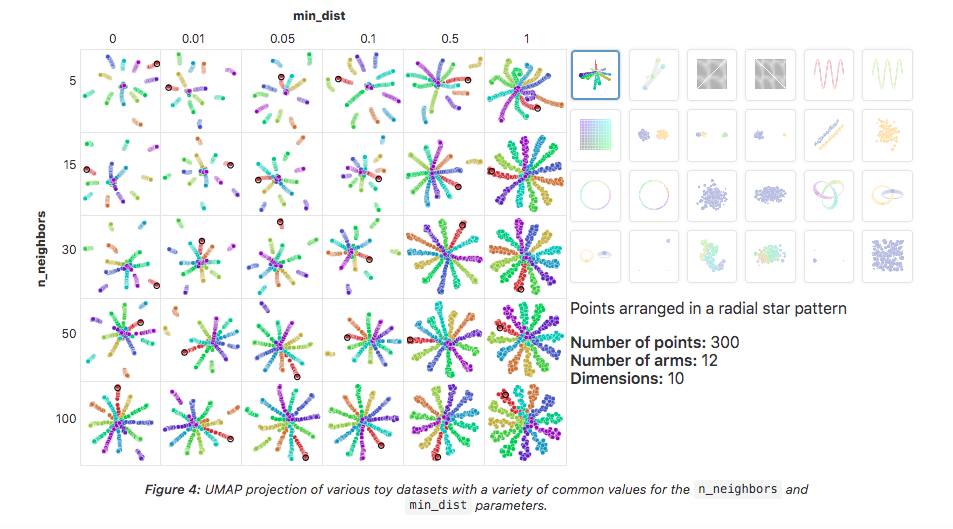

In [22]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import random
import numpy as np

# set the random seed for reproducibility
random.seed(32)                
np.random.seed(32)             

# load the model
model = SentenceTransformer('all-MiniLM-L6-v2')
# encode the sentences
embeddings = model.encode(item_list, show_progress_bar=True)

# reduce the dimensionality of the embeddings. 
# n_neighbors is the number of neighbors to consider when constructing the UMAP graph. For noisy data, larger n_neighbors may produce more stable embeddings.
# n_components is the number of dimensions to reduce to(output dimension). Use 2 for visulization purposes, try 5 later!
reducer = umap.UMAP(n_neighbors=200, n_components=200, metric='cosine', random_state=32)
embeddings = reducer.fit_transform(embeddings)



Batches:   0%|          | 0/106 [00:00<?, ?it/s]

c:\Users\AlanC\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
# clustering the reduced embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', prediction_data=True) # for min_cluster_size, Smaller → more (and smaller) clusters, Larger → fewer, more robust clusters

# fit the HDBSCAN model to the reduced embeddings
clusterer.fit(embeddings)
# get the cluster labels
labels = clusterer.labels_

In [ ]:
import random
from collections import defaultdict

# for reproducibility
random.seed(42)  

# Create a dictionary to hold sentences by cluster
cluster_dict = defaultdict(list)

# Fill the dictionary
for label, sentence in zip(clusterer.labels_, item_list):
    cluster_dict[label].append(sentence)

# Display a few clusters
for label in sorted(cluster_dict.keys()):
    print(f"\n=== Cluster {label} ===")
    cluster = cluster_dict[label]

    # randomly select 5 sentences from the cluster
    sample_size = min(15, len(cluster))
    sample = random.sample(cluster, sample_size) 
    
    for sentence in sample:
        print(f"{sentence}")
    if len(cluster) > 15:
        print(f"...and {len(cluster) - 15} more\n")


=== Cluster -1 ===
standard packaging no charge
boxes must be marked by stop&shop hand sanitizer
apply correct ingredients labels
items leaked on the original order
add 1 piece shipped from wc- logo: be quiet, be calm, be kind"
special package-3pcs per bag-one of each logo on same item color 
special package-4 blue pcs in a poly bag
individual package
logo to show through on same side as insert card
special package -tape bar code label on each box
broken case fee 
items need repackaged for shipping
assorted color per box
ship the 39 good pieces
special package- 10
...and 647 more


=== Cluster 0 ===
special package - core 365 jackets see spreadsheet female medium
special package - core 365 jackets see spreadsheet female  2xl
special package - core 365 jackets see spreadsheet female small
does not need sleeves
special package - core 365 jackets see spreadsheet male 2xl
special package - core 365 jackets see spreadsheet female large
special package - core 365 jackets see spreadsheet fem

# Visualization 

c:\Users\AlanC\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


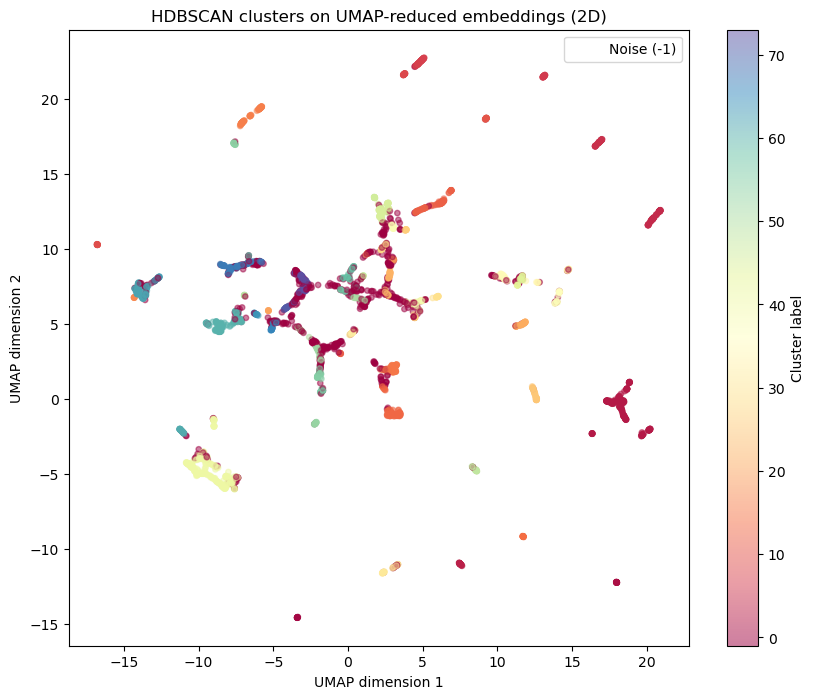

In [25]:
import umap
import matplotlib.pyplot as plt

# 1. Re‑embed into 2D for visualization
reducer_2d = umap.UMAP(
    n_neighbors=30,
    n_components=2,
    metric='cosine',
    random_state=42
)
embeds_2d = reducer_2d.fit_transform(embeddings)  # embeddings from your SentenceTransformer step

# 2. Scatter‑plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeds_2d[:, 0],
    embeds_2d[:, 1],
    c=labels,                  # labels from HDBSCAN
    cmap='Spectral',           # nice categorical palette
    s=15,                       # point size
    alpha=0.5                  
)
plt.colorbar(scatter, label='Cluster label')
plt.title('HDBSCAN clusters on UMAP-reduced embeddings (2D)')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')

# 3. Optional: highlight noise points
noise_mask = labels == -1
plt.scatter(
    embeds_2d[noise_mask, 0],
    embeds_2d[noise_mask, 1],
    # show noise points in transparent
    alpha=0, # comment out to see them
    c='black',
    s=1,
    label='Noise (-1)'
)
plt.legend(markerscale=2, frameon=True)
plt.show()


# Save the Model

In [ ]:
import joblib

# Save UMAP reducer and HDBSCAN clusterer
joblib.dump(reducer, 'my_umap_reducer.pkl')
joblib.dump(clusterer, 'my_hdbscan_clusterer.pkl')

['my_hdbscan_clusterer.pkl']